In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = '../../data/training/dev/data'
plot_folder = 'plots/dev'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
metrics_df = pd.read_parquet(os.path.join(folder, 'metrics.parquet'))
confusion_matrix_df = pd.read_parquet(os.path.join(folder, 'confusion_matrix.parquet'))
synthethetic_df = pd.read_parquet(os.path.join(folder, 'synthetic_predicitions.parquet'))

metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')
confusion_matrix_df['shuffle_feature'] = confusion_matrix_df['shuffle_feature'].fillna('none')

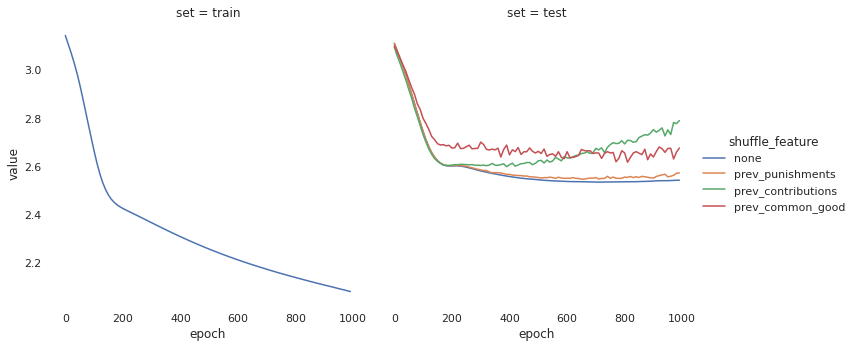

In [4]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss'
}

focus = ['shuffle_feature']

for f in focus:
    if f in selection:
        selection.pop(f)


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(data=metrics_df[w1 & w2].copy(), x='epoch', hue=focus[0], style=focus[1] if len(focus) >= 2 else None, y='value', col='set', row=focus[2] if len(focus) >= 3 else None, kind='line', ci=None)

In [5]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    sns.heatmap(cm)

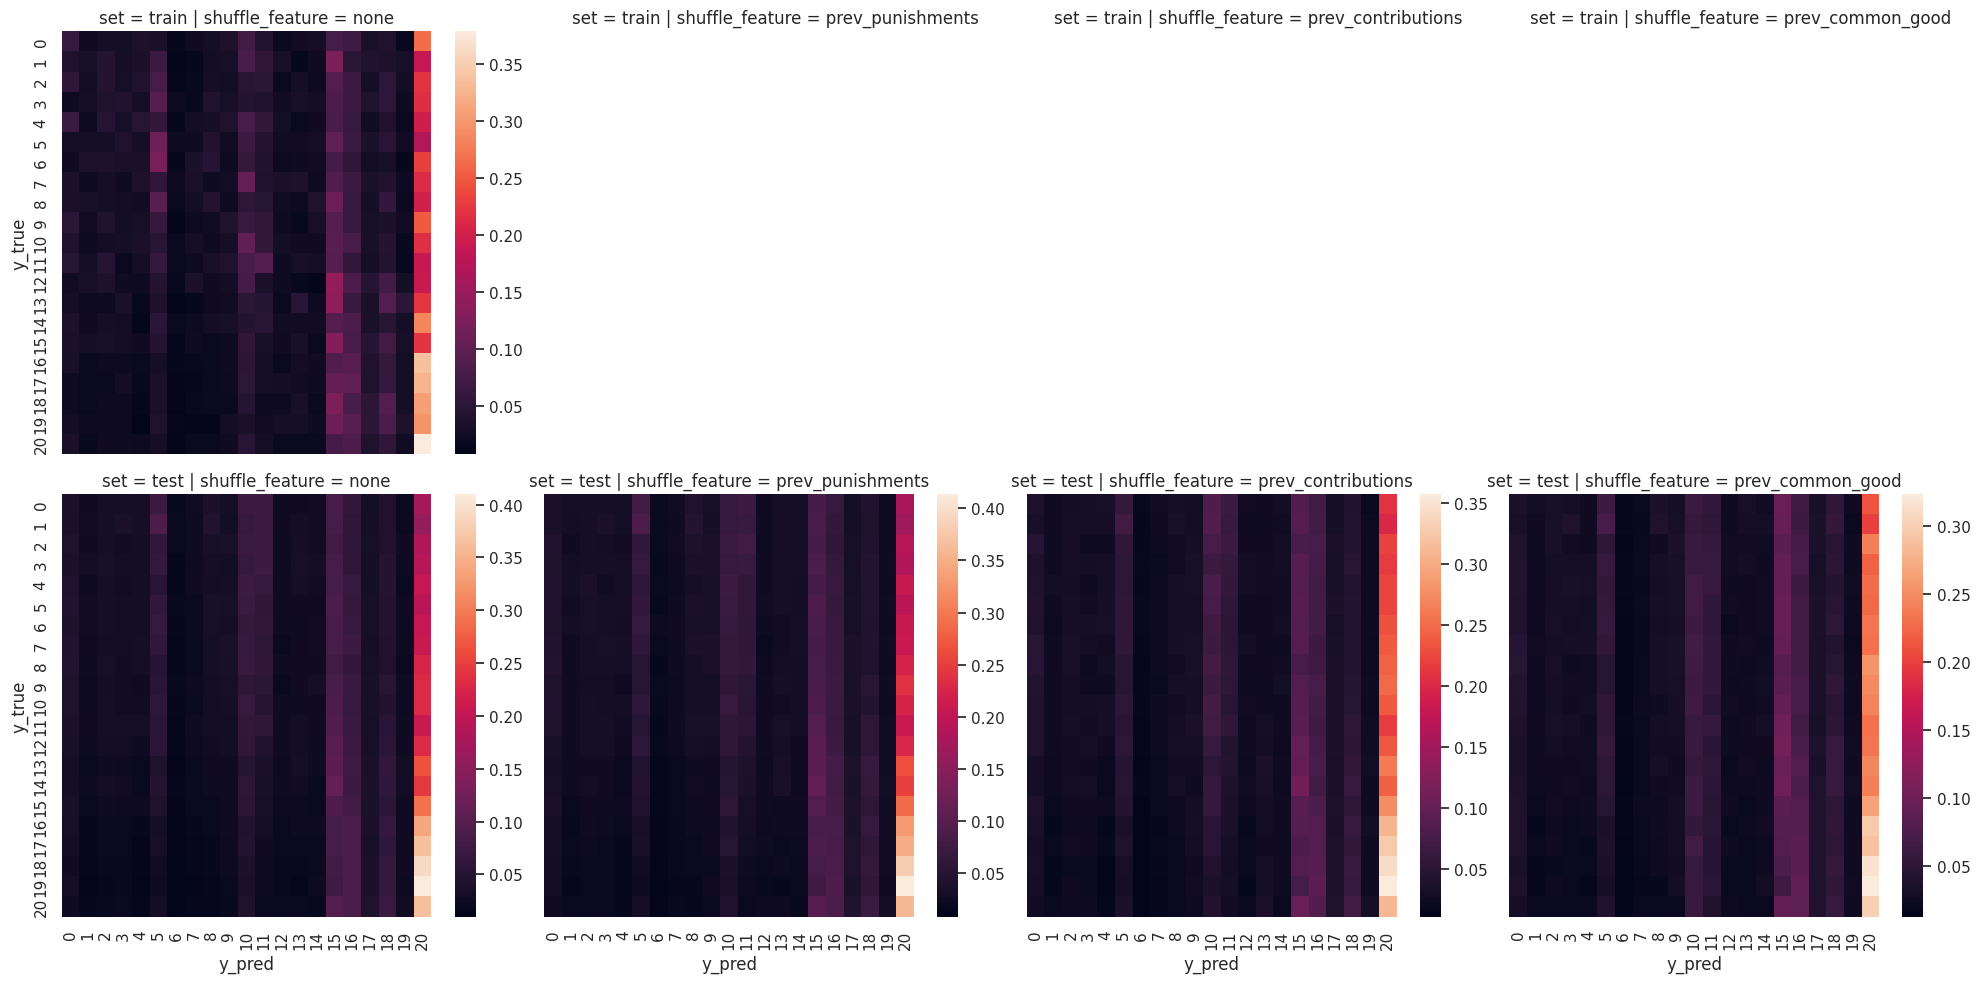

In [6]:
df = confusion_matrix_df.copy()

w = (
    # (df['shuffle_feature'] == 'None') &
    (df['strategy'] == 'sampling') 
    # (df['set'] == 'test')
)

df = df[w]

focus_dimensions = ['shuffle_feature', 'set']


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='y_true',y='y_pred', values='value')

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    height=5)
fg.map_dataframe(plot_heatmap)

In [7]:
synthethetic_df['set']

0        train
1        train
2        train
3        train
4        train
         ...  
41659    train
41660    train
41661    train
41662    train
41663    train
Name: set, Length: 83328, dtype: category
Categories (1, object): ['train']

In [8]:
[c for c in synthethetic_df.columns if c not in ['cv_split', 'exp_contribution']]

['set',
 'epoch',
 'idx',
 'round_number',
 'prev_punishments',
 'prev_contributions']

In [9]:
df = synthethetic_df.groupby(['idx'])['exp_contribution'].agg(prev_contributions='first')


In [ ]:
df

In [10]:
groupby = [c for c in synthethetic_df.columns if c not in ['cv_split', 'exp_contribution']]

df = synthethetic_df.groupby(groupby)['exp_contribution'].agg(prev_contributions='first')

# w = (
#     (df['shuffle_feature'] == 'None')
# )

# df = df[w]

focus_dimensions = ['round_number']


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_punishments',y='prev_contributions', values='exp_contribution', normalise=False)

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    height=5)
fg.map_dataframe(plot_heatmap)

: 

: 

In [ ]:
df

,idx,exp_contribution
0,0,9.294493
1,1,9.294493
2,2,9.294493
3,3,9.294493
4,4,9.260671
...,...,...
2599,2599,11.238806
2600,2600,11.184556
2601,2601,11.184556
2602,2602,11.184556


In [ ]:
synthethetic_df

,set,cv_split,epoch,idx,round_number,prev_punishments,prev_contributions,exp_contribution
0,train,0,999,0,0,15,10,7.475710
1,train,0,999,0,1,0,0,10.525946
2,train,0,999,0,2,0,0,10.527520
3,train,0,999,0,3,0,0,10.531406
4,train,0,999,0,4,0,0,10.537771
...,...,...,...,...,...,...,...,...
41659,train,1,999,2603,11,30,20,14.816557
41660,train,1,999,2603,12,30,20,14.915226
41661,train,1,999,2603,13,30,20,15.009914
41662,train,1,999,2603,14,30,20,15.100324


In [ ]:
cm = dfg.pivot_table(index=['prev_contribution'], columns='prev_punishment', values='exp_manager_payoff')

plt.figure(figsize=(14,10))
sns.heatmap(cm)

NameError: name 'dfg' is not defined

<AxesSubplot:xlabel='defect', ylabel='punishment'>

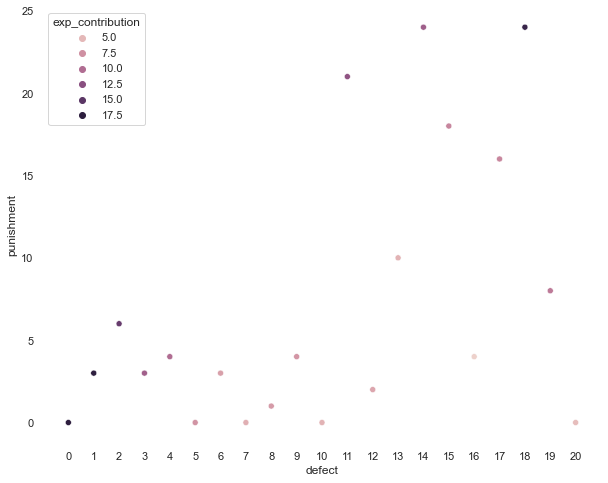

In [ ]:
df3 = df[df['best_exp_manager_payoff']].copy()
df3['defect'] = (20-df3['prev_contribution'])
df3['punishment'] = df['prev_punishment']
df3['exp_net_contribution'] = df3['exp_manager_payoff']
df3 = df3.sort_values('defect')
df3['defect'] = df3['defect'].astype(str)

plt.figure(figsize=(10,8))
sns.scatterplot(data=df3, x='defect', y='punishment', hue='exp_contribution')

In [ ]:
contribution_punishment_map = th.tensor(df3.sort_values('prev_contribution')['prev_punishment'].values)

In [ ]:
# from aimanager.model.neural.random import RandomArtificialHumans

%load_ext autoreload
%autoreload 2

artificial_humans = "../../data/dev/data/model.pt"

import torch as th
from aimanager.model.environment import ArtificialHumanEnv
from aimanager.model.artificial_humans import ArtificialHuman


device = th.device('cpu')
rec_device = th.device('cpu')
# rah = RandomArtificialHumans(device=device, max_contribution=20)
artifical_humans = ArtificialHuman.load(artificial_humans)

env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, n_agents=4, n_contributions=21, n_punishments=31, episode_steps=16, device=device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

rec = {
    'value': [],
    'name': [],
    'round_number': [],
    'episode': [],
    'player_id': [],
}

for i in range(45):
    state = env.init_episode()
    done = False
    rn = 0
    while not done:
        contributions = state['contributions']
        punishments = contribution_punishment_map[contributions]
        # punishments = th.randint(0, 31, (4,), device=device)
        state, reward, done = env.step(punishments)

        common_good = contributions * 1.6 - punishments

        rec['value'].extend(contributions.tolist()+punishments.tolist()+common_good.tolist())
        rec['name'].extend(['contributions']*4 + ['punishments']*4 + ['common_good']*4)
        rec['episode'].extend([i]*12)
        rec['round_number'].extend([rn]*12)
        rec['player_id'].extend([0,1,2,3]*3)
        rn += 1
        env.next_step()

<AxesSubplot:xlabel='round_number', ylabel='value'>

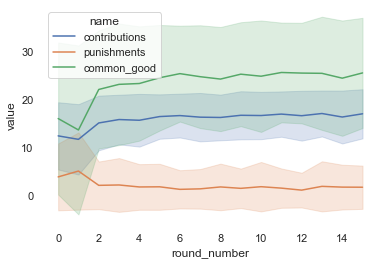

In [ ]:
df = pd.DataFrame(rec)

sns.lineplot(data=df, x='round_number', hue='name', y='value', ci='sd')

In [ ]:
df.to_parquet(os.path.join(folder, 'artificial_human_simulation.parquet'))